## Packages and Assets

In [3]:
import keras.models
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

import seaborn as sns
import json
import matplotlib.pyplot as plt
import numpy as np

from keras.preprocessing.text import tokenizer_from_json

from keras.utils import pad_sequences
import pandas as pd
import re
import string
import nltk


## Dependencies

In [ ]:
test_pp = pd.read_csv('../../assets/data/splits/test/preprocessed.csv')
test_pp

In [4]:
model = keras.models.load_model('../../assets/deep_assets/lstm_model')
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 11, 300)           3120900   
                                                                 
 bidirectional_2 (Bidirectio  (None, 11, 128)          186880    
 nal)                                                            
                                                                 
 dropout_2 (Dropout)         (None, 11, 128)           0         
                                                                 
 bidirectional_3 (Bidirectio  (None, 64)               41216     
 nal)                                                            
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dense_3 (Dense)             (None, 4)                

In [5]:
# Load the tokenizer from the file
with open('../../assets/deep_assets/tokenizer.json', 'r', encoding='utf-8') as f:
    tokenizer_json = f.read()
    tokenizer = tokenizer_from_json(tokenizer_json)
    word_index = tokenizer.word_index

## Predictions considering best deep model

In [7]:
X_test = test_pp.title
y_test = test_pp.to_numpy()[:, -1]

test_sequences = tokenizer.texts_to_sequences(X_test)
test_padded = pad_sequences(test_sequences, maxlen=11, padding='post', truncating='post')
test_padded

array([[  70,    5,   18, ..., 2510,  431,  326],
       [  26,  101,   11, ...,    0,    0,    0],
       [   7,  197,    2, ...,    0,    0,    0],
       ...,
       [   1,    1, 1853, ...,  174, 2044, 1178],
       [   3,  726, 1042, ...,   90,  119,    0],
       [6781, 4898, 1006, ...,    0,    0,    0]])

### Functions

In [8]:
def index2word(word_index):
    index_word = {}
    for key in word_index:
        index_word[word_index[key]] = key
    return index_word


def seq2text(seq, index_word):
    text = []
    for index in seq:
        text.append(index_word[index])
    return text

def show_confusion_matrix(cm):
        print("Confusion Matrix")
        plt.figure(figsize=(10, 7))

        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'],
                    yticklabels=['Negative', 'Positive'])
        plt.xlabel('Predicted')
        plt.ylabel('Truth')
        plt.title('Confusion Matrix')
        plt.show()

In [9]:
index_word = index2word(word_index)

In [10]:
pred_prob = model.predict(test_padded)

57/57 [==============================] - 4s 6ms/step


In [11]:
# y_pred = [1 if p > 0.5 else 0 for p in pred_prob]
y_pred = np.argmax(pred_prob, axis=1)

In [12]:
df_results = pd.DataFrame()
X_test = list(X_test)
y_test = list(y_test)
df_results['sequence'] = test_sequences
df_results['X_test'] = X_test
df_results['seq2text'] = df_results['sequence'].apply(lambda x: seq2text(x, index_word))
df_results['y_pred'] = y_pred
df_results['y_true'] = y_test
df_results

,sequence,X_test,seq2text,y_pred,y_true
0,"[70, 5, 18, 417, 110, 32, 23, 1084, 2510, 431,...",radar vale vale3 atualiza valor acao dividendo...,"[radar, vale, vale3, atualiza, valor, acao, di...",2,2
1,"[26, 101, 11, 2, 4, 319, 2]",dolar encerra alta <NUM> cento cotado <NUM>,"[dolar, encerra, alta, num, cento, cotado, num]",0,0
2,"[7, 197, 2, 60, 3024, 1, 886, 405]",itau pagara <NUM> mi cobranca indevida tarifas...,"[itau, pagara, num, mi, cobranca, <OOV>, tarif...",3,3
3,"[10, 729, 2872, 174, 407, 844, 150, 466]",ibovespa ganha folego opera estavel destaque e...,"[ibovespa, ganha, folego, opera, estavel, dest...",0,2
4,"[59, 86, 370, 8, 17, 83, 34, 625]",xp troca duas acoes carteira semanal veja port...,"[xp, troca, duas, acoes, carteira, semanal, ve...",1,2
...,...,...,...,...,...
1797,"[3, 9, 277, 2, 4, 1162, 104, 483, 165, 442, 182]",petrobras petr4 atinge <NUM> cento uso refinar...,"[petrobras, petr4, atinge, num, cento, uso, re...",1,1
1798,"[586, 6, 1027, 35, 2399, 1, 3262]",maia diz hora bolsonaro parar brincadeira trab...,"[maia, diz, hora, bolsonaro, parar, <OOV>, tra...",0,0
1799,"[1, 1, 1853, 1577, 1753, 1, 1554, 5211, 174, 2...",midas trend suposta piramide chegou patrocinar...,"[<OOV>, <OOV>, suposta, piramide, chegou, <OOV...",2,0
1800,"[3, 726, 1042, 2341, 1, 78, 1646, 133, 90, 119]",petrobras leva bloco itapu sozinha oferta mini...,"[petrobras, leva, bloco, itapu, <OOV>, oferta,...",1,1


### Metrics

In [13]:
# accuracy = accuracy_score(y_true=y_test, y_pred=y_pred)
# precision = precision_score(average='macro', y_true=y_test, y_pred=y_pred)
# recall = recall_score(average='macro', y_true=y_test, y_pred=y_pred)
# f1 = f1_score(average='macro', y_true=y_test, y_pred=y_pred)
# cm = confusion_matrix(y_true=y_test, y_pred=y_pred)

              precision    recall  f1-score   support

           0       0.77      0.89      0.83       565
           1       0.88      0.84      0.86       638
           2       0.83      0.81      0.82       379
           3       0.81      0.64      0.71       220

    accuracy                           0.82      1802
   macro avg       0.82      0.79      0.80      1802
weighted avg       0.83      0.82      0.82      1802

Confusion Matrix


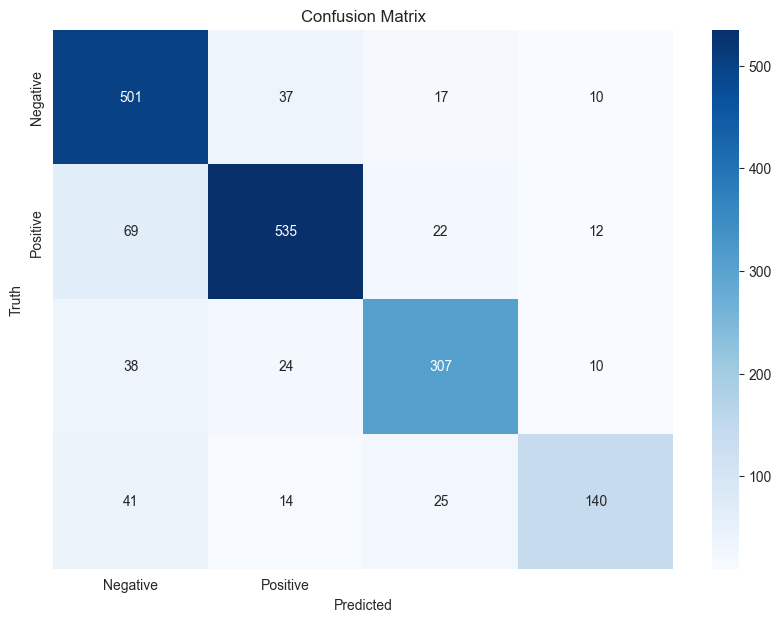

In [14]:
print(classification_report(y_test,y_pred))
cm = confusion_matrix(y_true=y_test, y_pred=y_pred)
show_confusion_matrix(cm)